In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import os
import h5py
from ast import literal_eval
import re
import pickle
import collections
import warnings
warnings.filterwarnings('ignore')

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn_extra.kernel_approximation import Fastfood
from sklearn.metrics import pairwise_distances

from deem import deem # proposed module, 'deem' is in short for 'de'-biasing 'em'beddings

In [2]:
# use a dict to align the classes between Openmic dataset (key) and Irmas dataset (val)
class_align = {'cello': 'cel',
               'clarinet': 'cla',
               'flute': 'flu',
               'guitar': ['gac', 'gel'],
               'organ': 'org',
               'piano': 'pia',
               'saxophone': 'sax',
               'trumpet': 'tru',
               'violin': 'vio',
               'voice': 'voi'}

classf_param = {'C': [10**k for k in range(-10, 4, 1)], 
                'metric': 'roc_auc', 'cv': 3}  

In [3]:
embeddings = ['vggish', 'openl3', 'yamnet']

# for plots
colors = ['#0271AE', '#DC2830']
dataset_name = ['IRMAS', 'OpenMIC']

deem = deem()

# -lda

## dataset separation direction

Loading irmas data:


  0%|          | 0/6705 [00:00<?, ?it/s]

Loading openmic data:


  0%|          | 0/20000 [00:00<?, ?it/s]

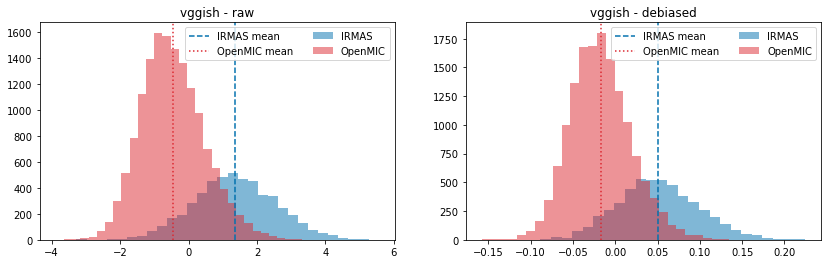

Loading irmas data:


  0%|          | 0/6705 [00:00<?, ?it/s]

Loading openmic data:


  0%|          | 0/20000 [00:00<?, ?it/s]

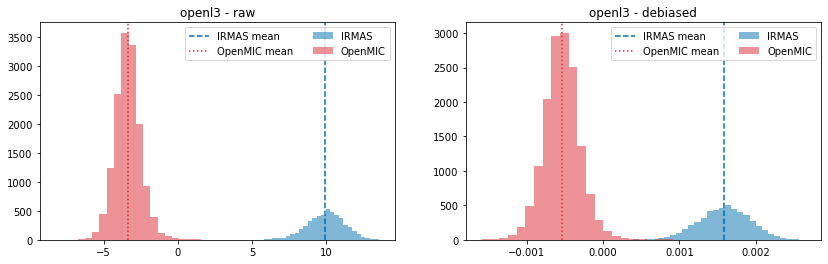

Loading irmas data:


  0%|          | 0/6705 [00:00<?, ?it/s]

Loading openmic data:


  0%|          | 0/20000 [00:00<?, ?it/s]

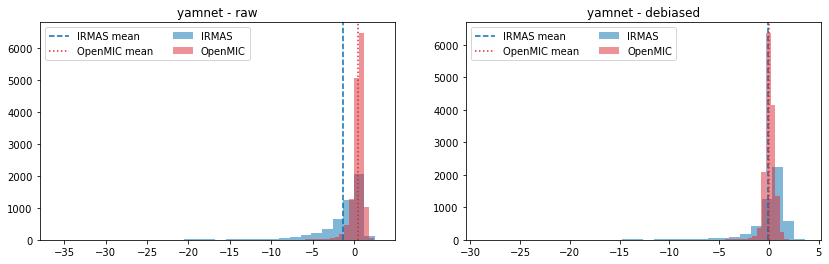

In [4]:
project_method = '-lda'  
deem.debias_method = ''  # orginal, no debiasing to get the original model 
debias_method = ''
deem.classf_param = classf_param

for embedding in embeddings:
    
    deem.embedding = embedding
    irmas_train, irmas_test = deem.data_loader(dataset='irmas', data_root='')
    openmic_train, openmic_test, openmic_mask = deem.data_loader(dataset='openmic', data_root='openmic-2018/')

    X_train = np.vstack((irmas_train[0], openmic_train[0]))
    Y_ir = np.zeros(len(irmas_train[0]))
    Y_om = np.ones(len(openmic_train[0]))
    Y = np.hstack((Y_ir, Y_om))
    
    # standardize embedding
    Scaler = StandardScaler()
    X_train = Scaler.fit_transform(X_train)
    
    # extract dataset separation direction by lda
    LDA = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
    LDA.fit(X_train, Y)

    v = LDA.coef_.copy()
    v /= np.sqrt(np.sum(v**2))
    A = np.outer(v, v)

    Xdeb = X_train.dot(np.eye(len(A)) - A)
    Xsproj = LDA.transform(X_train)
    Xdproj = LDA.transform(Xdeb)
    
    # plot
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    plt.title(f'{embedding} - raw')
    plt.hist(Xsproj[Y==0], color=colors[0], alpha=0.5, label=dataset_name[0], bins=30)
    plt.hist(Xsproj[Y==1], color=colors[1], alpha=0.5, label=dataset_name[1], bins=30)
    plt.axvline(Xsproj[Y==0].mean(), color=colors[0], linestyle='--', label='{} mean'.format(dataset_name[0]))
    plt.axvline(Xsproj[Y==1].mean(), color=colors[1], linestyle=':', label='{} mean'.format(dataset_name[1]))
    plt.legend(ncol=2)

    plt.subplot(122)
    plt.title(f'{embedding} - debiased')
    plt.hist(Xdproj[Y==0], color=colors[0], alpha=0.5, label=dataset_name[0], bins=30)
    plt.hist(Xdproj[Y==1], color=colors[1], alpha=0.5, label=dataset_name[1], bins=30)
    plt.axvline(Xdproj[Y==0].mean(), color=colors[0], linestyle='--', label='{} mean'.format(dataset_name[0]))
    plt.axvline(Xdproj[Y==1].mean(), color=colors[1], linestyle=':', label='{} mean'.format(dataset_name[1]))
    plt.legend(ncol=2)
    plt.show()

    # save dataset separation direction
    with open('models/LDAcoef_' + embedding + project_method + '.pickle', 'wb') as fdesc:
        pickle.dump(LDA.coef_, fdesc)

## cosine similarity

In [5]:
# # train instrument classification model on irmas and openmic
    
# for embedding in embeddings:
    
#     deem.embedding = embedding
#     irmas_train, irmas_test = deem.data_loader(dataset='irmas', data_root='')
#     openmic_train, openmic_test, openmic_mask = deem.data_loader(dataset='openmic', data_root='openmic-2018/')

#     train, test = deem.projection(irmas_train, irmas_test)
#     irmas_train, irmas_test = (train, irmas_train[1]), (test, irmas_test[1])
#     deem.irmas_irmas(irmas_train, irmas_test)

#     train, test = deem.projection(openmic_train, openmic_test)
#     openmic_train, openmic_test = (train, openmic_train[1]), (test, openmic_test[1])
#     deem.openmic_openmic(openmic_train, openmic_test, openmic_mask)

In [6]:
# cosine_sim = pd.DataFrame({'instrument': [],
#                            'embedding': [],
#                            'train set': [],
#                           'cosine similarity': [],
#                          })


# for embedding in ['vggish', 'openl3', 'yamnet']:
#     file = open('models/LDAcoef_' + embedding + project_method + '.pickle', 'rb')
#     globals()['LDAcoef_' + embedding] = pickle.load(file)
#     file.close()
    
#     # load the trained instrument classification model
#     file = open('models/models_irmas_' + embedding + debias_method + '.pickle', 'rb')
#     globals()['models_' + embedding + '_irmas'] = pickle.load(file)
#     file.close()

#     file = open('models/models_openmic_' + embedding + debias_method + '.pickle', 'rb')
#     globals()['models_' + embedding + '_openmic'] = pickle.load(file)
#     file.close()
    
#     globals()['sim_' + embedding + '_irmas'] = []
#     globals()['sim_' + embedding + '_openmic'] = []

#     for key in class_align:
#         globals()['sim_' + embedding + '_irmas'].append(cosine_similarity(
#             globals()['models_' + embedding + '_irmas'][key].best_estimator_.coef_, globals()['LDAcoef_' + embedding])[0][0])
#         globals()['sim_' + embedding + '_openmic'].append(cosine_similarity(
#             globals()['models_' + embedding + '_openmic'][key].best_estimator_.coef_, globals()['LDAcoef_' + embedding])[0][0])
        
#     embedding_sim = pd.DataFrame({'instrument': list(class_align.keys()) * 2,
#                        'embedding': [embedding] * len(class_align) * 2,
#                        'train set': ['irmas'] * len(class_align) + ['openmic'] * len(class_align),
#                        'cosine similarity': globals()['sim_' + embedding + '_irmas'] + 
#                                             globals()['sim_' + embedding + '_openmic']
#                      })
    
#     cosine_sim = cosine_sim.append(embedding_sim)
    
# cosine_sim.to_csv('results/cosine_similarity.csv', index=False)

In [7]:
# sns.set_theme(context='notebook', style='whitegrid', font_scale=1.6)
# colors = ['green', 'orange', '#0e668b']
# hue_order = ['vggish', 'openl3', 'yamnet']
    
# df = pd.read_csv('results/cosine_similarity.csv')
# df['cosine similarity'] = abs(df['cosine similarity'])
# ax = sns.catplot(data=df, col='train set', x='instrument', y='cosine similarity', hue='embedding', kind='bar', aspect=2, 
#                legend_out=False, palette=colors, hue_order=hue_order, alpha = 0.8)
# a0 = ax.fig.axes[0]
# a0.set_title("(a) train = irmas")
# handles, labels = a0.get_legend_handles_labels()
# df_irmas = df[df['train set']=='irmas']
# text = [a0.legend(ncol=1).get_texts()[l].get_text() + ' (' + \
#         str(np.round(df_irmas[df_irmas['embedding']==hue_order[l]]['cosine similarity'].mean(), 3)) + ')' for l in range(len(hue_order))]
# a0.legend(handles, text, ncol=1)
# a1 = ax.fig.axes[1]
# a1.set_title("(b) train = openmic")
# handles, labels = a1.get_legend_handles_labels()
# df_openmic = df[df['train set']=='openmic']
# text = [a1.legend(ncol=1).get_texts()[l].get_text() + ' (' + \
#         str(np.round(df_openmic[df_openmic['embedding']==hue_order[l]]['cosine similarity'].mean(), 3)) + ')' for l in range(len(hue_order))]
# a1.legend(handles, text, ncol=1)

# ax.set(xlabel=None)
# plt.subplots_adjust(wspace=0.15)
# ax.set_xticklabels(rotation=30)
# plt.savefig('results/cosine_similarity.pdf', bbox_inches='tight')
# plt.savefig('results/cosine_similarity.png', bbox_inches='tight')

# -klda

## dataset separation direction

Loading irmas data:


  0%|          | 0/6705 [00:00<?, ?it/s]

Loading openmic data:


  0%|          | 0/20000 [00:00<?, ?it/s]

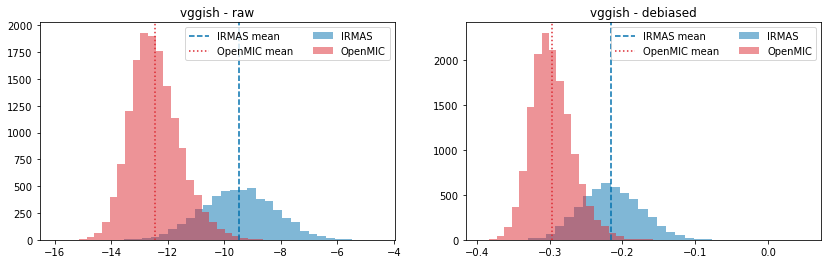

Loading irmas data:


  0%|          | 0/6705 [00:00<?, ?it/s]

Loading openmic data:


  0%|          | 0/20000 [00:00<?, ?it/s]

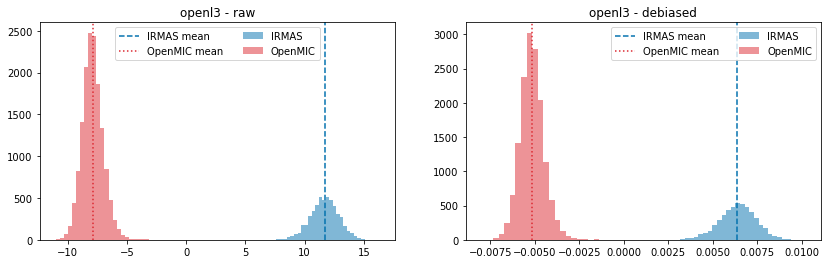

Loading irmas data:


  0%|          | 0/6705 [00:00<?, ?it/s]

Loading openmic data:


  0%|          | 0/20000 [00:00<?, ?it/s]

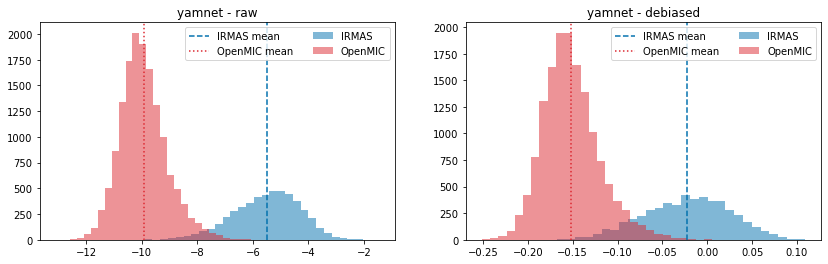

In [8]:
project_method = '-klda'  
deem.debias_method = '-k'  
debias_method = '-k'
deem.classf_param = classf_param

for embedding in embeddings:
    
    deem.embedding = embedding
    irmas_train, irmas_test = deem.data_loader(dataset='irmas', data_root='')
    openmic_train, openmic_test, openmic_mask = deem.data_loader(dataset='openmic', data_root='openmic-2018/')

    X_train = np.vstack((irmas_train[0], openmic_train[0]))
    Y_ir = np.zeros(len(irmas_train[0]))
    Y_om = np.ones(len(openmic_train[0]))
    Y = np.hstack((Y_ir, Y_om))

    # standardize embedding
    Scaler = StandardScaler()
    X_train = Scaler.fit_transform(X_train)
    
    # kernelize embedding with fastfood
    Sampler = Fastfood(n_components=4*X_train.shape[1], random_state=0,
                                    sigma=np.median(pairwise_distances(X_train, metric='l2')))
    X_train = Sampler.fit_transform(X_train)
    
    # extract dataset separation direction by lda
    LDA = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
    LDA.fit(X_train, Y)

    v = LDA.coef_.copy()
    v /= np.sqrt(np.sum(v**2))
    A = np.outer(v, v)

    Xdeb = X_train.dot(np.eye(len(A)) - A)
    Xsproj = LDA.transform(X_train)
    Xdproj = LDA.transform(Xdeb)
    
    # plot
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    plt.title(f'{embedding} - raw')
    plt.hist(Xsproj[Y==0], color=colors[0], alpha=0.5, label=dataset_name[0], bins=30)
    plt.hist(Xsproj[Y==1], color=colors[1], alpha=0.5, label=dataset_name[1], bins=30)
    plt.axvline(Xsproj[Y==0].mean(), color=colors[0], linestyle='--', label='{} mean'.format(dataset_name[0]))
    plt.axvline(Xsproj[Y==1].mean(), color=colors[1], linestyle=':', label='{} mean'.format(dataset_name[1]))
    plt.legend(ncol=2)

    plt.subplot(122)
    plt.title(f'{embedding} - debiased')
    plt.hist(Xdproj[Y==0], color=colors[0], alpha=0.5, label=dataset_name[0], bins=30)
    plt.hist(Xdproj[Y==1], color=colors[1], alpha=0.5, label=dataset_name[1], bins=30)
    plt.axvline(Xdproj[Y==0].mean(), color=colors[0], linestyle='--', label='{} mean'.format(dataset_name[0]))
    plt.axvline(Xdproj[Y==1].mean(), color=colors[1], linestyle=':', label='{} mean'.format(dataset_name[1]))
    plt.legend(ncol=2)
    plt.show()

    # save dataset separation direction
    with open('models/LDAcoef_' + embedding + project_method + '.pickle', 'wb') as fdesc:
        pickle.dump(LDA.coef_, fdesc)

## cosine similarity

In [9]:
# # train instrument classification model on irmas and openmic
    
# for embedding in embeddings:
    
#     deem.embedding = embedding
#     irmas_train, irmas_test = deem.data_loader(dataset='irmas', data_root='')
#     openmic_train, openmic_test, openmic_mask = deem.data_loader(dataset='openmic', data_root='openmic-2018/')

#     train, test = deem.projection(irmas_train, irmas_test)
#     irmas_train, irmas_test = (train, irmas_train[1]), (test, irmas_test[1])
#     deem.irmas_irmas(irmas_train, irmas_test)

#     train, test = deem.projection(openmic_train, openmic_test)
#     openmic_train, openmic_test = (train, openmic_train[1]), (test, openmic_test[1])
#     deem.openmic_openmic(openmic_train, openmic_test, openmic_mask)

In [10]:
# cosine_sim = pd.DataFrame({'instrument': [],
#                            'embedding': [],
#                            'train set': [],
#                           'cosine similarity': [],
#                          })

# for embedding in ['vggish', 'openl3', 'yamnet']:
#     file = open('models/LDAcoef_' + embedding + project_method + '.pickle', 'rb')
#     globals()['LDAcoef_' + embedding] = pickle.load(file)
#     file.close()
    
#     # load the trained instrument classification model
#     file = open('models/models_irmas_' + embedding + debias_method + '.pickle', 'rb')
#     globals()['models_' + embedding + '_irmas'] = pickle.load(file)
#     file.close()

#     file = open('models/models_openmic_' + embedding + debias_method + '.pickle', 'rb')
#     globals()['models_' + embedding + '_openmic'] = pickle.load(file)
#     file.close()
    
#     globals()['sim_' + embedding + '_irmas'] = []
#     globals()['sim_' + embedding + '_openmic'] = []

#     for key in class_align:
#         globals()['sim_' + embedding + '_irmas'].append(cosine_similarity(
#             globals()['models_' + embedding + '_irmas'][key].best_estimator_.coef_, globals()['LDAcoef_' + embedding])[0][0])
#         globals()['sim_' + embedding + '_openmic'].append(cosine_similarity(
#             globals()['models_' + embedding + '_openmic'][key].best_estimator_.coef_, globals()['LDAcoef_' + embedding])[0][0])
        
#     embedding_sim = pd.DataFrame({'instrument': list(class_align.keys()) * 2,
#                        'embedding': [embedding] * len(class_align) * 2,
#                        'train set': ['irmas'] * len(class_align) + ['openmic'] * len(class_align),
#                        'cosine similarity': globals()['sim_' + embedding + '_irmas'] + 
#                                             globals()['sim_' + embedding + '_openmic']
#                      })
    
#     cosine_sim = cosine_sim.append(embedding_sim)
    
# cosine_sim.to_csv('results/cosine_similarity_kernelize.csv', index=False)

In [11]:
# sns.set_theme(context='notebook', style='whitegrid', font_scale=1.6)
# colors = ['green', 'orange', '#0e668b']
# hue_order = ['vggish', 'openl3', 'yamnet']
    
# df = pd.read_csv('results/cosine_similarity_kernelize.csv')
# df['cosine similarity'] = abs(df['cosine similarity'])
# ax = sns.catplot(data=df, col='train set', x='instrument', y='cosine similarity', hue='embedding', kind='bar', aspect=2, 
#                legend_out=False, palette=colors, hue_order=hue_order, alpha = 0.8)
# a0 = ax.fig.axes[0]
# a0.set_title("(a) train = irmas")
# handles, labels = a0.get_legend_handles_labels()
# df_irmas = df[df['train set']=='irmas']
# text = [a0.legend(ncol=1).get_texts()[l].get_text() + ' (' + \
#         str(np.round(df_irmas[df_irmas['embedding']==hue_order[l]]['cosine similarity'].mean(), 3)) + ')' for l in range(len(hue_order))]
# a0.legend(handles, text, ncol=1)
# a1 = ax.fig.axes[1]
# a1.set_title("(b) train = openmic")
# handles, labels = a1.get_legend_handles_labels()
# df_openmic = df[df['train set']=='openmic']
# text = [a1.legend(ncol=1).get_texts()[l].get_text() + ' (' + \
#         str(np.round(df_openmic[df_openmic['embedding']==hue_order[l]]['cosine similarity'].mean(), 3)) + ')' for l in range(len(hue_order))]
# a1.legend(handles, text, ncol=1)

# ax.set(xlabel=None)
# plt.subplots_adjust(wspace=0.15)
# ax.set_xticklabels(rotation=30)
# plt.savefig('results/cosine_similarity_kernelize.pdf', bbox_inches='tight')
# plt.savefig('results/cosine_similarity_kernelize.png', bbox_inches='tight')

# -lda-genre

In [12]:
# irmas genre information: country-folk ([cou_fol]), classical ([cla]), pop-rock ([pop-roc]), latin-soul ([lat-sou]).
aligned_genre = ['pop_roc', 'jazz_blue', 'classical', 'country_folk', 'latin_soul']

# load embeddings
embedding_data = h5py.File('embeddings.h5', 'r')

project_method = '-lda-genre'  

In [13]:
def data_loader(embedding, dataset, data_root):
    feature = np.array(embedding_data[dataset][embedding]['features'])
    keys_ori = np.array(embedding_data[dataset][embedding]['keys'])
    key_clip = np.unique(keys_ori)

    feature_clip = []
    for key in tqdm(key_clip):
        feature_clip.append(np.mean(feature[keys_ori[:]==key,:],axis=0))
    feature_clip = np.array(feature_clip)

    key_clip = np.array([str(k, 'utf-8') for k in key_clip])
    
    if dataset == 'irmas':
        key_train = set(pd.read_csv(data_root + 'irmas_train.csv', header=None, squeeze=True))
        key_test = set(pd.read_csv(data_root + 'irmas_test.csv', header=None, squeeze=True))
    else: # dataset == 'openmic'
        key_train = set(pd.read_csv(data_root + 'openmic2018_train.csv', header=None, squeeze=True))
        key_test = set(pd.read_csv(data_root + 'openmic2018_test.csv', header=None, squeeze=True))

    # These loops go through all sample keys, and save their row numbers to either idx_train or idx_test
    idx_train, idx_test = [], []

    for k in range(len(key_clip)):
        if str(key_clip[k]) in key_train:
            idx_train.append(k)
        elif str(key_clip[k]) in key_test:
            idx_test.append(k)
        else:
            # This should never happen, but better safe than sorry.
            raise RuntimeError('Unknown sample key={}! Abort!'.format(key_clip[k]))

    # cast the idx_* arrays to numpy structures
    idx_train = np.asarray(idx_train)
    idx_test = np.asarray(idx_test)

    return feature_clip, key_clip, idx_train, idx_test

In [14]:
def list_match(A, B):
    ele_A = set(map(str.lower, A))
    ele_B = set(map(str.lower, B))
    return bool(ele_A & ele_B)

In [15]:
for embedding in embeddings:
    
    ###### irmas
    dataset = 'irmas'; data_root = ''
    feature_clip, key_clip, idx_train, idx_test = data_loader(embedding, dataset, data_root)

    key_train = np.array(key_clip[idx_train])
    key_train_genre = [key[key.rindex('[')+1:key.rindex(']')] for key in key_train]

    # align genre
    key_train_genre = ['jazz_blue' if item =='jaz_blu' else item for item in key_train_genre]
    key_train_genre = ['classical' if item =='cla' else item for item in key_train_genre]
    key_train_genre = ['country_folk' if item =='cou_fol' else item for item in key_train_genre]
    key_train_genre = ['latin_soul' if item =='lat_sou' else item for item in key_train_genre]

    X_train_ir = feature_clip[idx_train,:]
    Y_ir = np.zeros(len(X_train_ir))
    Y_genre_ir = np.array(key_train_genre)

    ###### openmic
    dataset = 'openmic'; data_root = 'openmic-2018/'
    feature_clip, key_clip, idx_train, idx_test = data_loader(embedding, dataset, data_root)
    
    # key-label map using the information from the dataset source
    meta = pd.read_csv(data_root + 'openmic-2018-metadata.csv')
    train_genre_meta = list(meta['track_genres'][idx_train])

    key_genre_om = []

    for k in tqdm(range(len(train_genre_meta))):
        if isinstance(train_genre_meta[k], str):
            key_genre_om.append(literal_eval(train_genre_meta[k])[0]['genre_title'])
        else:
            key_genre_om.append('other')

    key_genre_om_align = []

    for item in key_genre_om:
        key_genre_om_item = re.split('[^a-zA-Z]', item)
        genre_match = 'other'
        for genre in aligned_genre:
            genre_item = re.split('[^a-zA-Z]', genre)
            if list_match(key_genre_om_item, genre_item):
                genre_match = genre
                continue
        key_genre_om_align.append(genre_match)

    key_genre_om = key_genre_om_align

    X_train_om = feature_clip[idx_train]
    Y_om = np.ones(len(X_train_om))
    Y_genre_om = np.array(key_genre_om)

    X_train = np.vstack((X_train_ir, X_train_om))
    Y = np.hstack((Y_ir, Y_om))
    Y_genre = np.hstack((Y_genre_ir, Y_genre_om))
    
    # standardize embedding
    Scaler = StandardScaler()
    X_train = Scaler.fit_transform(X_train)
    
    # loop for each genre
    globals()['LDAcoef_'+embedding] = []

    for genre in aligned_genre:
        X_train_sub = X_train[Y_genre == genre]
        Y_sub = Y[Y_genre == genre]
        print(X_train_sub.shape, Y_sub.shape, collections.Counter(Y_sub))

        LDA = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
        LDA.fit(X_train_sub, Y_sub)

        globals()['LDAcoef_'+embedding].append(LDA.coef_.copy())

    globals()['LDAcoef_'+embedding] = np.squeeze(np.array(globals()['LDAcoef_'+embedding]))
    print(globals()['LDAcoef_'+embedding].shape)

    with open('models/LDAcoef_' + embedding + project_method + '.pickle', 'wb') as fdesc:
        pickle.dump(globals()['LDAcoef_'+embedding], fdesc)

  0%|          | 0/6705 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/14915 [00:00<?, ?it/s]

(2679, 128) (2679,) Counter({0.0: 1853, 1.0: 826})
(2317, 128) (2317,) Counter({0.0: 1539, 1.0: 778})
(2087, 128) (2087,) Counter({0.0: 1240, 1.0: 847})
(1418, 128) (1418,) Counter({1.0: 1053, 0.0: 365})
(118, 128) (118,) Counter({1.0: 76, 0.0: 42})
(5, 128)


  0%|          | 0/6705 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/14915 [00:00<?, ?it/s]

(2679, 512) (2679,) Counter({0.0: 1853, 1.0: 826})
(2317, 512) (2317,) Counter({0.0: 1539, 1.0: 778})
(2087, 512) (2087,) Counter({0.0: 1240, 1.0: 847})
(1418, 512) (1418,) Counter({1.0: 1053, 0.0: 365})
(118, 512) (118,) Counter({1.0: 76, 0.0: 42})
(5, 512)


  0%|          | 0/6705 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/14915 [00:00<?, ?it/s]

(2679, 1024) (2679,) Counter({0.0: 1853, 1.0: 826})
(2317, 1024) (2317,) Counter({0.0: 1539, 1.0: 778})
(2087, 1024) (2087,) Counter({0.0: 1240, 1.0: 847})
(1418, 1024) (1418,) Counter({1.0: 1053, 0.0: 365})
(118, 1024) (118,) Counter({1.0: 76, 0.0: 42})
(5, 1024)


# -klda-genre

In [16]:
project_method = '-klda-genre'  

for embedding in embeddings:
    
    ###### irmas
    dataset = 'irmas'; data_root = ''
    feature_clip, key_clip, idx_train, idx_test = data_loader(embedding, dataset, data_root)

    key_train = np.array(key_clip[idx_train])
    key_train_genre = [key[key.rindex('[')+1:key.rindex(']')] for key in key_train]

    # align genre
    key_train_genre = ['jazz_blue' if item =='jaz_blu' else item for item in key_train_genre]
    key_train_genre = ['classical' if item =='cla' else item for item in key_train_genre]
    key_train_genre = ['country_folk' if item =='cou_fol' else item for item in key_train_genre]
    key_train_genre = ['latin_soul' if item =='lat_sou' else item for item in key_train_genre]

    X_train_ir = feature_clip[idx_train,:]
    Y_ir = np.zeros(len(X_train_ir))
    Y_genre_ir = np.array(key_train_genre)

    ###### openmic
    dataset = 'openmic'; data_root = 'openmic-2018/'
    feature_clip, key_clip, idx_train, idx_test = data_loader(embedding, dataset, data_root)
    
    # key-label map using the information from the dataset source
    meta = pd.read_csv(data_root + 'openmic-2018-metadata.csv')
    train_genre_meta = list(meta['track_genres'][idx_train])

    key_genre_om = []

    for k in tqdm(range(len(train_genre_meta))):
        if isinstance(train_genre_meta[k], str):
            key_genre_om.append(literal_eval(train_genre_meta[k])[0]['genre_title'])
        else:
            key_genre_om.append('other')

    key_genre_om_align = []

    for item in key_genre_om:
        key_genre_om_item = re.split('[^a-zA-Z]', item)
        genre_match = 'other'
        for genre in aligned_genre:
            genre_item = re.split('[^a-zA-Z]', genre)
            if list_match(key_genre_om_item, genre_item):
                genre_match = genre
                continue
        key_genre_om_align.append(genre_match)

    key_genre_om = key_genre_om_align

    X_train_om = feature_clip[idx_train]
    Y_om = np.ones(len(X_train_om))
    Y_genre_om = np.array(key_genre_om)

    X_train = np.vstack((X_train_ir, X_train_om))
    Y = np.hstack((Y_ir, Y_om))
    Y_genre = np.hstack((Y_genre_ir, Y_genre_om))
    
    # standardize embedding
    Scaler = StandardScaler()
    X_train = Scaler.fit_transform(X_train)

    # kernelize embedding with fastfood
    Sampler = Fastfood(n_components=4*X_train.shape[1], random_state=0,
                                    sigma=np.median(pairwise_distances(X_train, metric='l2')))
    X_train = Sampler.fit_transform(X_train)
    
    # loop for each genre
    globals()['LDAcoef_'+embedding] = []

    for genre in aligned_genre:
        X_train_sub = X_train[Y_genre == genre]
        Y_sub = Y[Y_genre == genre]
        print(X_train_sub.shape, Y_sub.shape, collections.Counter(Y_sub))

        LDA = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
        LDA.fit(X_train_sub, Y_sub)

        globals()['LDAcoef_'+embedding].append(LDA.coef_.copy())

    globals()['LDAcoef_'+embedding] = np.squeeze(np.array(globals()['LDAcoef_'+embedding]))
    print(globals()['LDAcoef_'+embedding].shape)

    with open('models/LDAcoef_' + embedding + project_method + '.pickle', 'wb') as fdesc:
        pickle.dump(globals()['LDAcoef_'+embedding], fdesc)

  0%|          | 0/6705 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/14915 [00:00<?, ?it/s]

(2679, 1024) (2679,) Counter({0.0: 1853, 1.0: 826})
(2317, 1024) (2317,) Counter({0.0: 1539, 1.0: 778})
(2087, 1024) (2087,) Counter({0.0: 1240, 1.0: 847})
(1418, 1024) (1418,) Counter({1.0: 1053, 0.0: 365})
(118, 1024) (118,) Counter({1.0: 76, 0.0: 42})
(5, 1024)


  0%|          | 0/6705 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/14915 [00:00<?, ?it/s]

(2679, 4096) (2679,) Counter({0.0: 1853, 1.0: 826})
(2317, 4096) (2317,) Counter({0.0: 1539, 1.0: 778})
(2087, 4096) (2087,) Counter({0.0: 1240, 1.0: 847})
(1418, 4096) (1418,) Counter({1.0: 1053, 0.0: 365})
(118, 4096) (118,) Counter({1.0: 76, 0.0: 42})
(5, 4096)


  0%|          | 0/6705 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/14915 [00:00<?, ?it/s]

(2679, 8192) (2679,) Counter({0.0: 1853, 1.0: 826})
(2317, 8192) (2317,) Counter({0.0: 1539, 1.0: 778})
(2087, 8192) (2087,) Counter({0.0: 1240, 1.0: 847})
(1418, 8192) (1418,) Counter({1.0: 1053, 0.0: 365})
(118, 8192) (118,) Counter({1.0: 76, 0.0: 42})
(5, 8192)
